<a href="https://colab.research.google.com/github/dokeyuka/deep-learning-practice/blob/main/DL_practice_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列データ
## オーバーフローを起こさないために
## 重みの初期化：直交行列
## 活性化関数：ReLUではなくtanh
## を用いる

In [8]:
import numpy as np

def sin(x, T = 100):
  return np.sin(2.0*np.pi*x/T)

def toy_problem(T = 100, ampl = 0.05):
  x = np.arange(0, 2*T+1)
  noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size = len(x))
  return sin(x)+noise

T = 100
f = toy_problem(T).astype(np.float32)
print(f.shape)

length_of_sequences = len(f)#2T+1

(201,)


In [12]:
maxlen = 25
x = []#input
t = []#output

print(f[0:0+maxlen])
for i in range(length_of_sequences-maxlen):
  x.append(f[i:i+maxlen])
  t.append(f[i+maxlen])

x = np.array(x).reshape(-1,maxlen,1)
t = np.array(t).reshape(-1,1)
print(x.shape)#行176*列25
print(t.shape)#行176*列１
#print(t)

[-0.03787452  0.06633663  0.10099953  0.15041898  0.21635829  0.28820324
  0.39758396  0.4697639   0.44633898  0.5473348   0.612563    0.6581827
  0.72137666  0.7038989   0.81368273  0.7876223   0.84826946  0.88365877
  0.91569823  0.95036817  0.9423942   0.96353734  0.9989709   1.009194
  1.0388076 ]
(176, 25, 1)
(176, 1)


In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch.optim as optimizers
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class EarlyStopping:
  def __init__(self, patience = 0, verbose = 0):
    #self._step 連続で最小値を上回ったepoch数を保持
    self._step = 0
    #self._loss 誤差の最小値を保持
    self._loss = float('inf')
    self.patience = patience
    self.verbose = verbose
  
  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1
      if self._step > self.patience:
        if self.verbose:
          print('early stopping')
          return True
    else:
        self._step = 0
        self._loss = loss
    return False  



class RNN(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    # batch_first = Trueで(データ数N,　時系列長tau,　入力次元l)の順にデータを与える
    self.l1 = nn.RNN(1, hidden_dim, 
                     nonlinearity = 'tanh',
                     batch_first = True)
    
    self.l2 = nn.Linear(hidden_dim, 1)
    
    nn.init.xavier_normal_(self.l1.weight_ih_l0)#入力層-隠れ層(input-hidden)の重みの初期化,l0:一つ目の隠れ層
    nn.init.orthogonal_(self.l1.weight_hh_l0)#隠れ層-隠れ層(hidden-hidden)の重みの初期化

  def forward(self, x):
    #戻り値(各時刻における隠れ層の出力、隠れ層の値)
    h, _ = self.l1(x)
    #出力層には最後の時刻の隠れ層の出力を与える
    y = self.l2(h[:,-1])

    return y




if __name__ == '__main__':
  np.random.seed(123)
  #torch用の乱数シード
  torch.manual_seed(123)

  #deviceに実行環境を格納して同じコードでCPUでもGPUでも対応できるように
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
  1 データの準備
'''
maxlen = 25
x = []
t = []
for i in range(length_of_sequences-maxlen):
  x.append(f[i:i+maxlen])
  t.append(f[i+maxlen])

x = np.array(x).reshape(-1,maxlen,1)
t = np.array(t).reshape(-1,1)

#時系列順にするためshuffle = False
x_train, x_val, t_train, t_val = train_test_split(x,t,test_size = 0.2, shuffle = False)



'''
2 modelの構築
'''
#隠れ層の次元50
model = RNN(50).to(device)

'''
3 modelの学習
'''
#平均2乗誤差(ばっちごとの平均なのでreduction = mean)
criterion = nn.MSELoss(reduction = 'mean')
optimizer = optimizers.Adam(model.parameters(),
                            lr = 0.001,
                            betas = (0.9,0.999),
                            amsgrad = True)
def compute_loss(t,y):
  return criterion(y, t)

def train_step(x,t):
  x = torch.Tensor(x).to(device)
  t = torch.Tensor(t).to(device)
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds

def val_step(x,t):
  x = torch.Tensor(x).to(device)
  t = torch.Tensor(t).to(device)
  model.eval()
  preds = model(x)
  loss = criterion(preds,t)
  return loss, preds

epochs = 1000
batch_size = 100
n_batches_train = x_train.shape[0]//batch_size +1
print(n_batches_train)
n_batches_val = x_val.shape[0]//batch_size + 1
hist = {'loss':[], 'val_loss':[]}
es = EarlyStopping(patience = 10, verbose = 1)

for epoch in range(epochs):
  train_loss = 0.
  val_loss = 0.
  x_, t_ = shuffle(x_train, t_train) 

  for batch in range(n_batches_train):
    start = batch*batch_size
    end = start + batch_size
    loss, _ = train_step(x_[start:end], t_[start:end])
    train_loss += loss.item()

  for batch in range(n_batches_val):
    start = batch*batch_size
    end = start + batch_size
    loss, _ = val_step(x_val[start:end], t_val[start:end])
    val_loss += loss.item()

  train_loss /= n_batches_train
  val_loss /= n_batches_val

  hist['loss'].append(train_loss)
  hist['val_loss'].append(val_loss)

  print('epoch:{}, loss:{:.3}, val_loss:{:.3f}'.format(
      epoch+1,
      train_loss,
      val_loss
  ))

  if es(val_loss):
    break


'''
  4 モデルの評価
'''
model.eval()

#sin波の予測
sin_wave = toy_problem(T, ampl = 0.)
gen = [None for i in range(maxlen)]
z = x[:1]

for i in range(length_of_sequences - maxlen):
  z_ = torch.Tensor(z[-1:]).to(device)
  preds = model(z_).data.cpu().numpy()
  z = np.append(z, preds)[1:]
  z = z.reshape(-1, maxlen, 1)
  gen.append(preds[0,0])








2
epoch:1, loss:0.556, val_loss:0.649
epoch:2, loss:0.429, val_loss:0.553
epoch:3, loss:0.352, val_loss:0.488
epoch:4, loss:0.28, val_loss:0.399
epoch:5, loss:0.226, val_loss:0.279
epoch:6, loss:0.156, val_loss:0.168
epoch:7, loss:0.113, val_loss:0.097
epoch:8, loss:0.0694, val_loss:0.062
epoch:9, loss:0.0571, val_loss:0.049
epoch:10, loss:0.0383, val_loss:0.041
epoch:11, loss:0.0265, val_loss:0.031
epoch:12, loss:0.0228, val_loss:0.022
epoch:13, loss:0.0234, val_loss:0.022
epoch:14, loss:0.025, val_loss:0.025
epoch:15, loss:0.0227, val_loss:0.022
epoch:16, loss:0.0203, val_loss:0.015
epoch:17, loss:0.0183, val_loss:0.013
epoch:18, loss:0.0167, val_loss:0.016
epoch:19, loss:0.0147, val_loss:0.017
epoch:20, loss:0.0143, val_loss:0.016
epoch:21, loss:0.013, val_loss:0.013
epoch:22, loss:0.0125, val_loss:0.012
epoch:23, loss:0.0104, val_loss:0.011
epoch:24, loss:0.00949, val_loss:0.012
epoch:25, loss:0.00824, val_loss:0.012
epoch:26, loss:0.0075, val_loss:0.012
epoch:27, loss:0.00735, val

TypeError: ignored

In [18]:
print(z.shape)

(1, 25, 1)


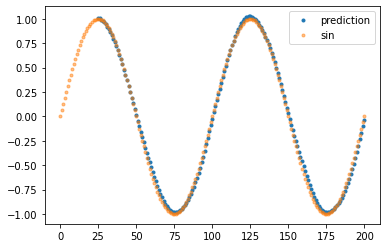

In [28]:
fig = plt.figure()
plt.plot(gen, '.', label = 'prediction')
plt.plot(sin, '.', alpha = 0.5,label =  'sin')
plt.legend()